In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad  

import numpy as np         
      
import matplotlib.pyplot as plt  

In [ ]:
m = 1.0
mu = 4.0
k = 400.0
lambda1 = 1e-1
lambda2 = 1e-4
lr = 0.002

In [ ]:
torch.set_default_dtype(torch.float64)
device = torch.device("cpu")
torch.manual_seed(0)

t = torch.linspace(0, 1, 200, device=device).reshape(-1, 1)
t = t.requires_grad_(True)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.net(x)

class CC_PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch1 = MLP()
        self.branch2 = MLP()

    def forward(self, t):
        return self.branch1(t) + self.branch2(t)

In [ ]:
model = CC_PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)

In [ ]:
def derivative(u, t):
    return grad(
        outputs=u,
        inputs=t,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

def second_derivative(u, t):
    du_dt = derivative(u, t)
    return derivative(du_dt, t)

In [ ]:
def loss_fn(model, t):

    u = model(t)
    
    du = derivative(u, t)
    d2u = second_derivative(u, t)

    f = m * d2u + mu * du + k * u

    t0 = torch.tensor([[0.0]], device=device, requires_grad=True)
    u0 = model(t0)
    du0 = derivative(u0, t0)

    loss_ic = (u0 - 1.0)**2 + lambda1 * du0**2
    loss_f  = lambda2 * torch.mean(f**2)

    return loss_ic + loss_f

Epoch    0 | Loss = 9.177e-01


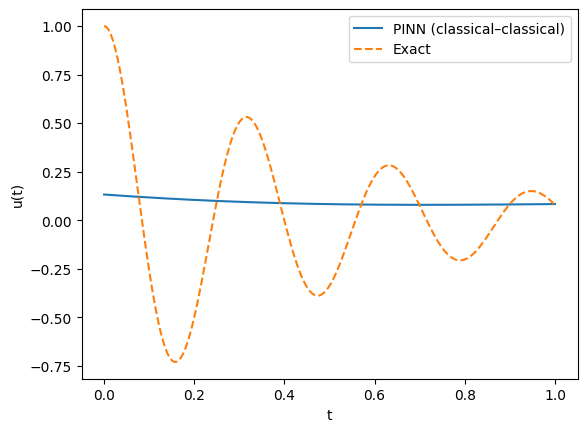

Epoch  600 | Loss = 7.014e-01


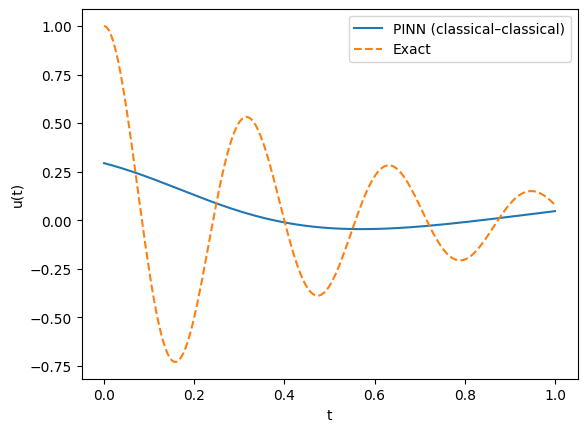

Epoch 1200 | Loss = 8.215e-02


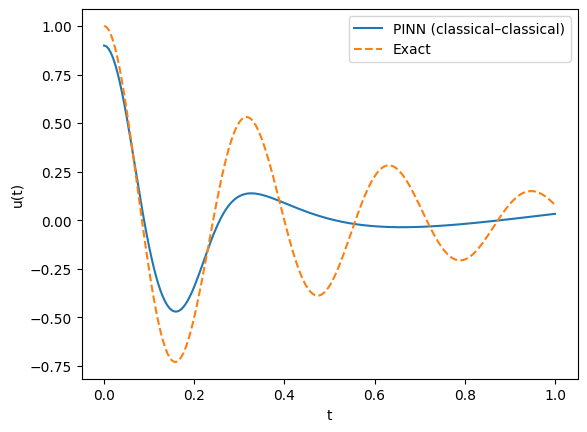

Epoch 1800 | Loss = 3.960e-02


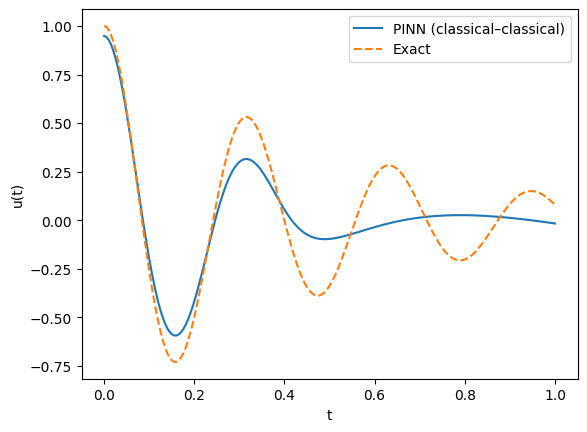

Epoch 2400 | Loss = 3.418e-02


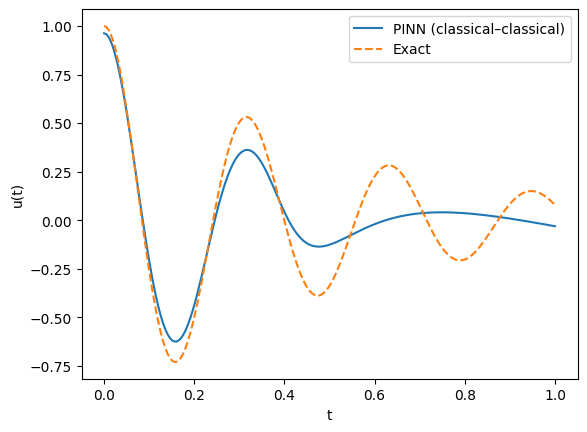

Epoch 3000 | Loss = 2.708e-02


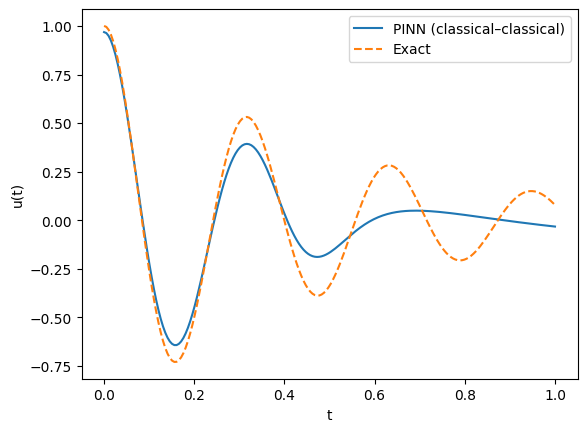

Epoch 3600 | Loss = 1.628e-02


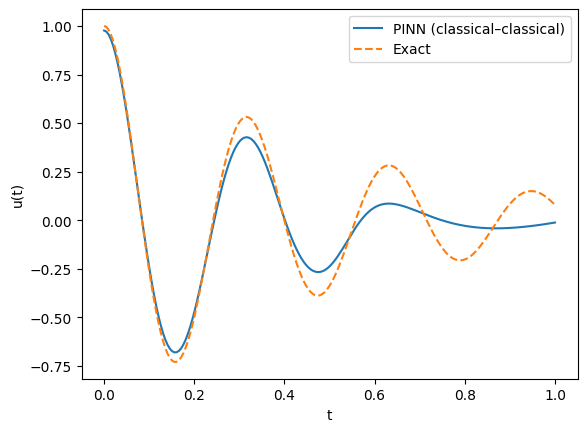

Epoch 4200 | Loss = 1.146e-02


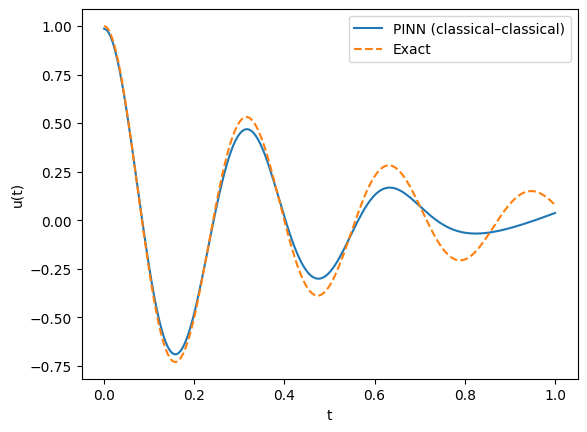

Epoch 4800 | Loss = 1.023e-02


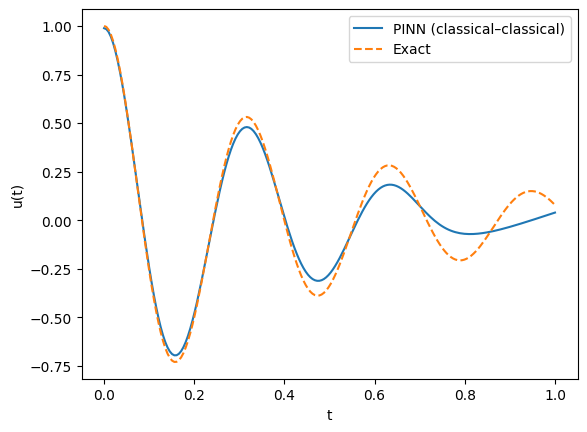

Epoch 5400 | Loss = 9.743e-03


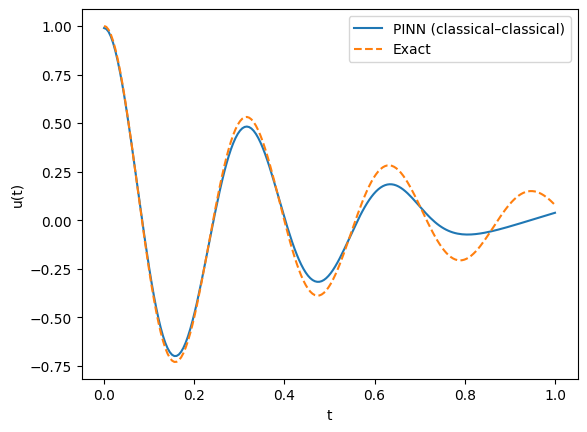

Epoch 6000 | Loss = 9.294e-03


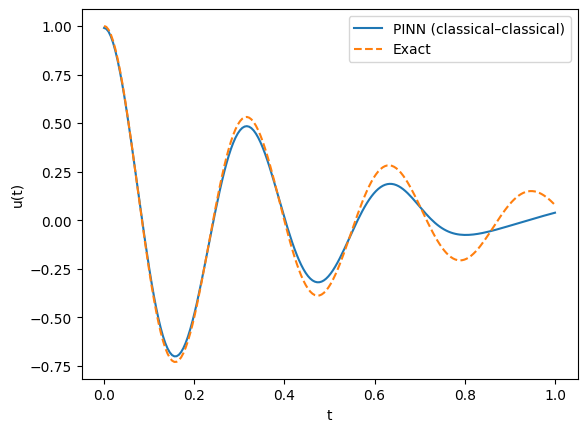

Epoch 6600 | Loss = 8.653e-03


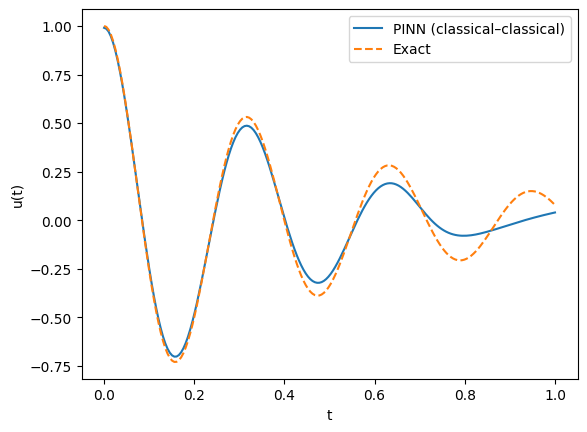

Epoch 7200 | Loss = 6.638e-03


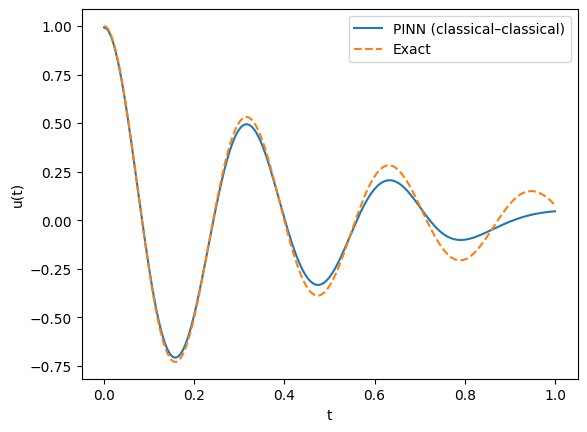

Epoch 7800 | Loss = 3.145e-03


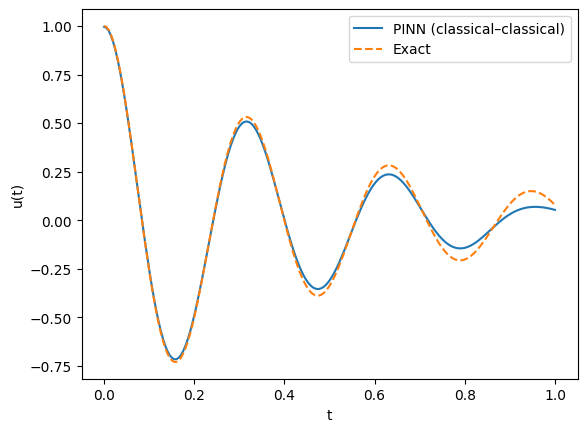

Epoch 8400 | Loss = 1.975e-03


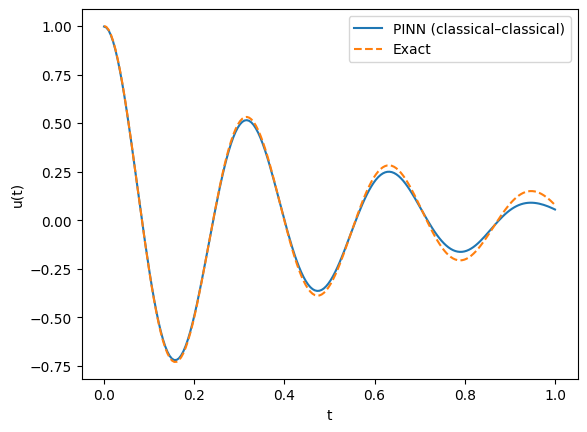

Epoch 9000 | Loss = 1.520e-03


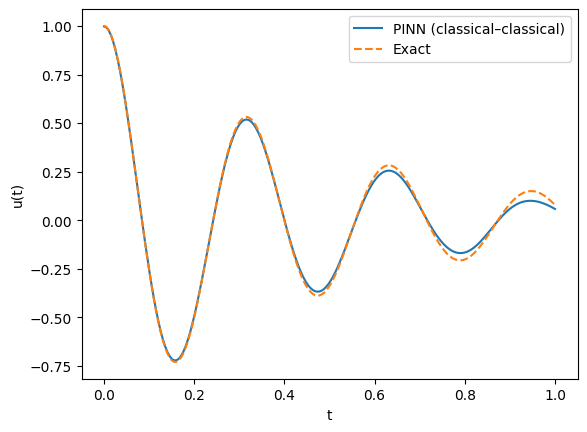

Epoch 9600 | Loss = 1.216e-03


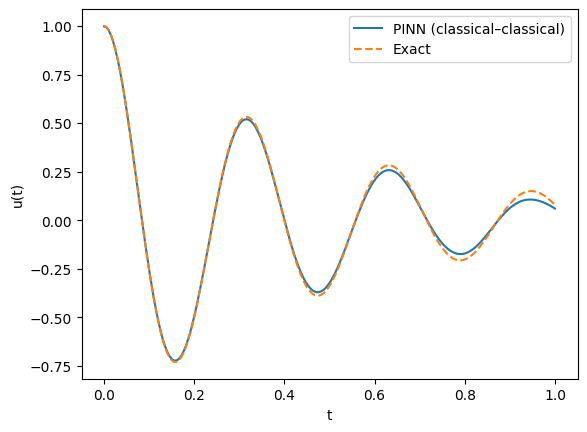

Epoch 10200 | Loss = 1.011e-03


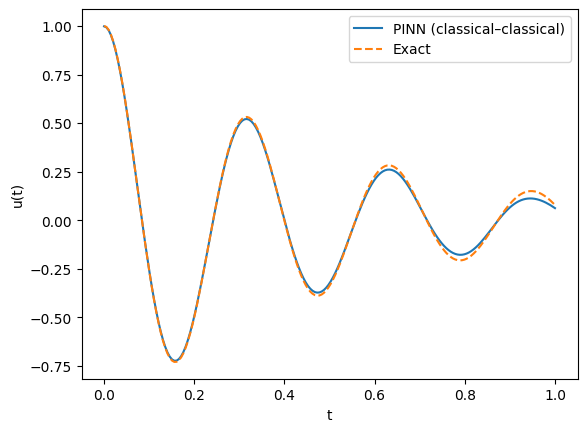

Epoch 10800 | Loss = 8.839e-04


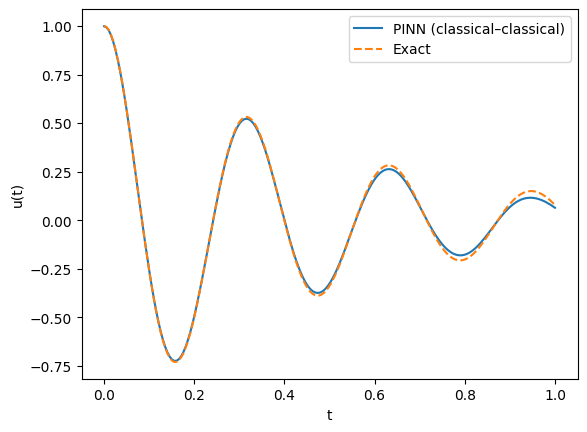

Epoch 11400 | Loss = 7.742e-04


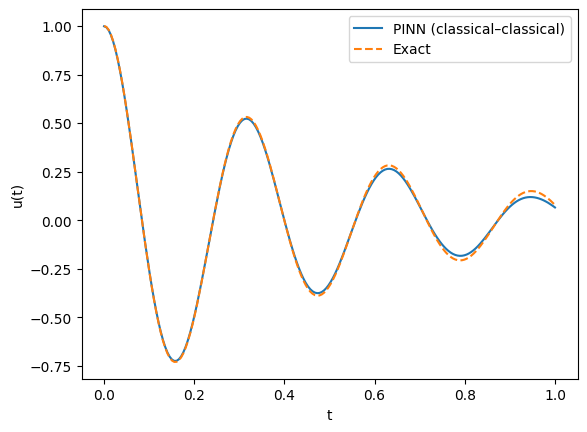

Epoch 12000 | Loss = 6.886e-04


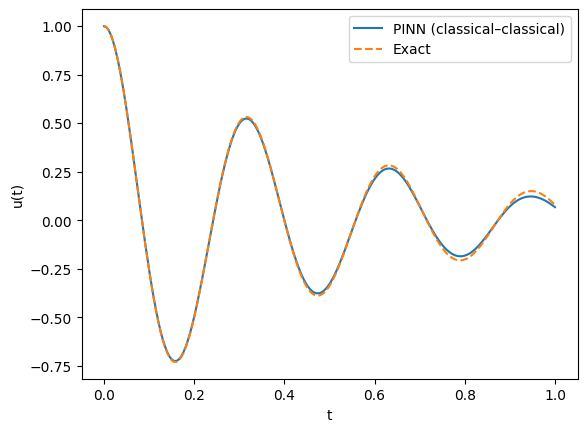

Epoch 12600 | Loss = 6.204e-04


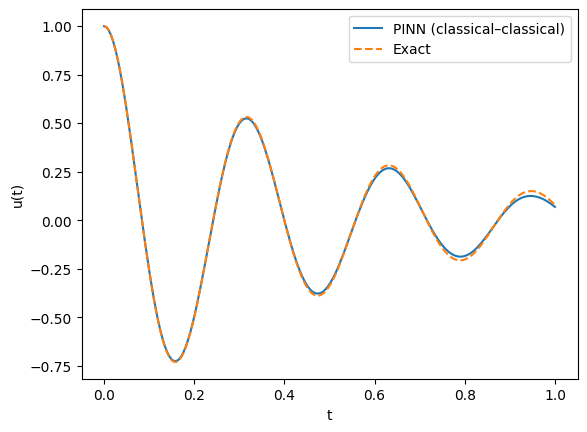

Epoch 13200 | Loss = 1.238e-03


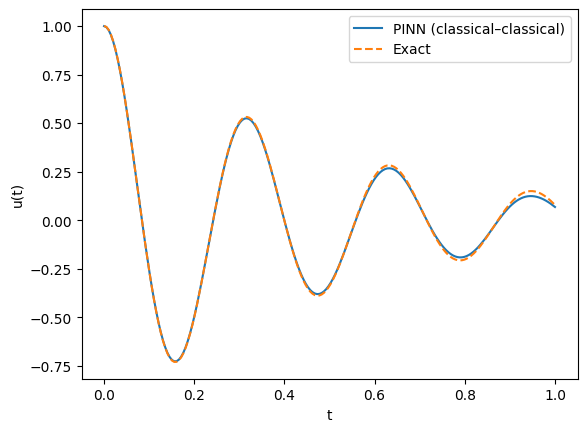

Epoch 13800 | Loss = 5.367e-04


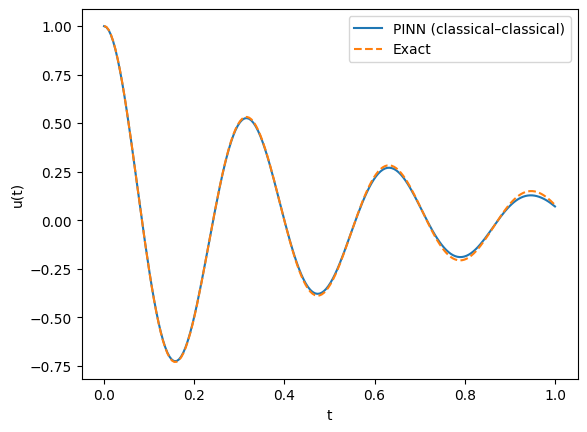

Epoch 14400 | Loss = 4.980e-04


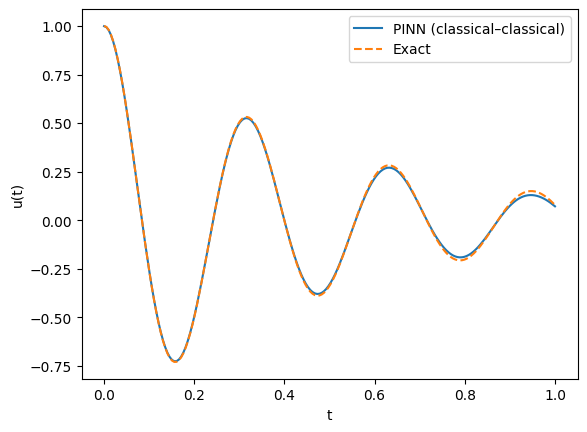

Epoch 15000 | Loss = 4.670e-04


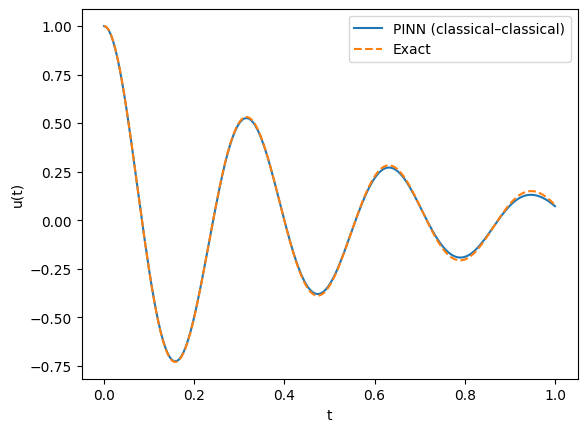

Epoch 15600 | Loss = 4.405e-04


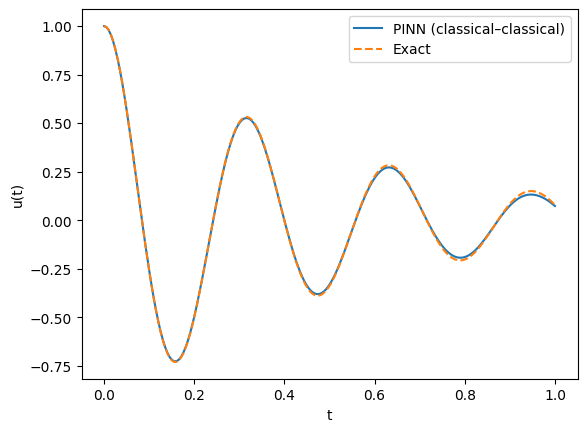

Epoch 16200 | Loss = 4.178e-04


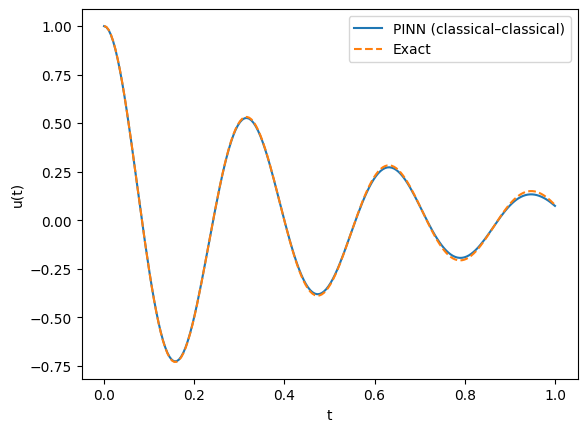

Epoch 16800 | Loss = 3.982e-04


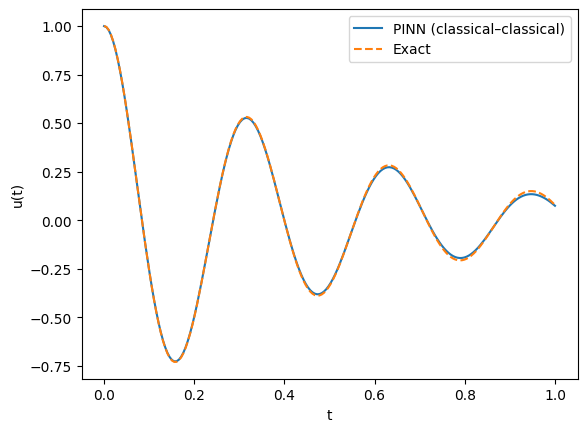

Epoch 17400 | Loss = 3.809e-04


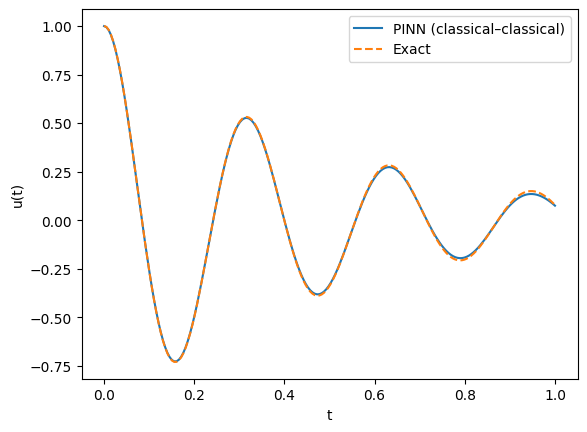

Epoch 18000 | Loss = 3.655e-04


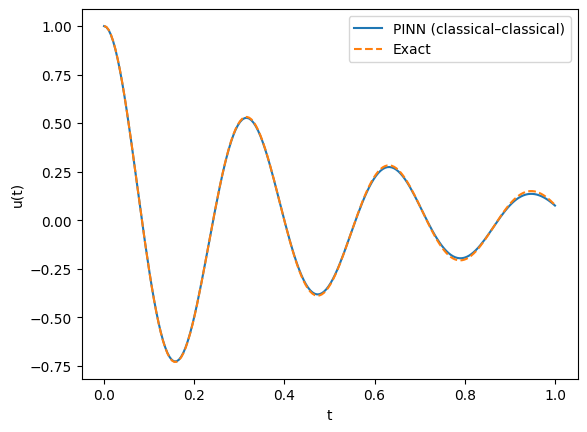

Epoch 18600 | Loss = 3.516e-04


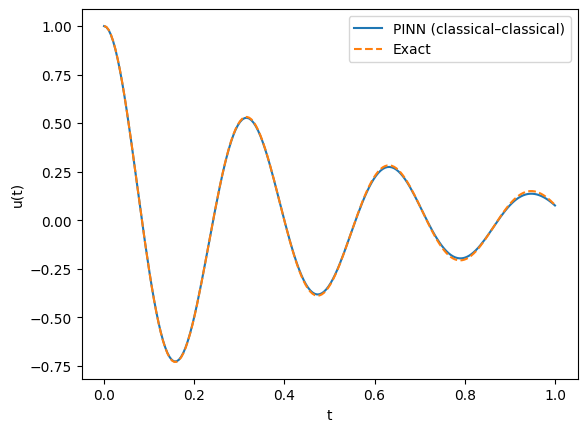

Epoch 19200 | Loss = 3.329e-03


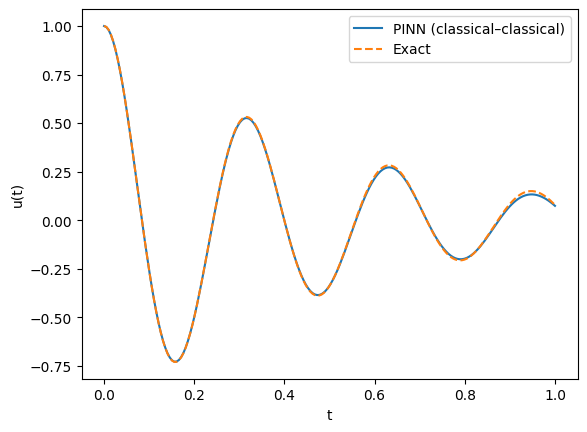

Epoch 19800 | Loss = 3.339e-04


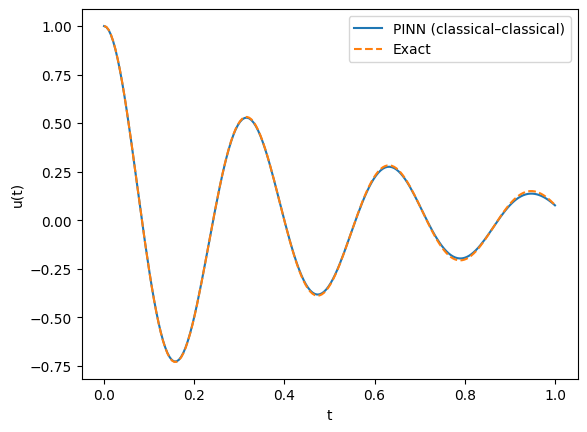

In [ ]:
model = CC_PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

n_epochs = 2700

omega = np.sqrt(k - (mu/2)**2)

def u_exact(t):
    return np.exp(-mu*t/2) * (np.cos(omega*t) + (mu/(2*omega))*np.sin(omega*t))

for epoch in range(n_epochs):
    optimizer.zero_grad()
    l = loss_fn(model, t)
    l.backward()
    optimizer.step()
    
    if epoch % 600 == 0:
        print(f"Epoch {epoch:4d} | Loss = {l.item():.3e}")
        with torch.no_grad():
            u_pred = model(t).cpu().numpy().flatten() 
        t_np = t.detach().cpu().numpy().flatten()
        u_ex = u_exact(t_np)

        plt.plot(t_np, u_pred, label="PINN (classical–classical)")
        plt.plot(t_np, u_ex, '--', label="Exact")
        plt.legend()
        plt.xlabel("t")
        plt.ylabel("u(t)")
        plt.show()